# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import get_dataframe_for_pretraining, encode_categorical

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = get_dataframe_for_pretraining(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
28638321,1,of,ADP,prep,NONE
28186515,4,by,ADP,prep,NONE
7655875,7,slightly,ADV,advmod,NONE
2862792,91,a,DET,det,NONE
13853016,3,1829,NUM,pobj,DATE
19359450,3,Besonders,NOUN,compound,NONE
17535392,1,and,CCONJ,cc,NONE
18844451,2,like,ADP,prep,NONE
19475820,18,routinely,ADV,advmod,NONE
15012036,1,a,DET,det,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}
encoded_df, encoder_mappings = encode_categorical(df_out, cols_to_encode)

In [7]:
encoded_df.sample(15)

,sentence_id,token,ner_tag,pos,dep
20462423,0,Kent,12,11,15
13550679,0,Димов,14,11,14
24830651,4,(,9,12,41
15530799,7,the,9,5,20
25333935,2,Henrik,14,11,14
29198218,0,.,9,12,41
16681589,18,proportions,9,7,35
33184530,0,100,9,8,31
20558573,2,to,1,1,39
9458476,3,Paramhansa,12,11,14


Now we proceed as we did in the CoNLL notebook.

In [8]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [9]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [10]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [11]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

This model, unlike the CoNLL one, we do need to save!

In [12]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")
log_path = os.path.join("models", f"clf_born_{timestamp}")
print(f"[+] Saved to {joblib.dump(born, log_path)}.")

[+] Saved to ['models/clf_born_22082024-105935'].


In [13]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.44      0.31      0.36     63436
           1       0.93      0.39      0.55    249104
           2       0.36      0.52      0.43     26271
           3       0.30      0.19      0.24     29201
           4       0.75      0.49      0.60    178202
           5       0.52      0.89      0.66      3200
           6       0.01      0.26      0.02      4311
           7       0.11      0.48      0.18     40975
           8       0.02      0.61      0.04      4175
           9       0.98      0.47      0.63   3995742
          10       0.76      0.70      0.73     55509
          11       0.07      0.97      0.13     18210
          12       0.86      0.15      0.26    369133
          13       0.07      0.57      0.12      3533
          14       0.12      0.93      0.22    259175
          15       0.10      0.29      0.15      7962
          16       0.59      0.49      0.53     28976
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [14]:
labels = encoder_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

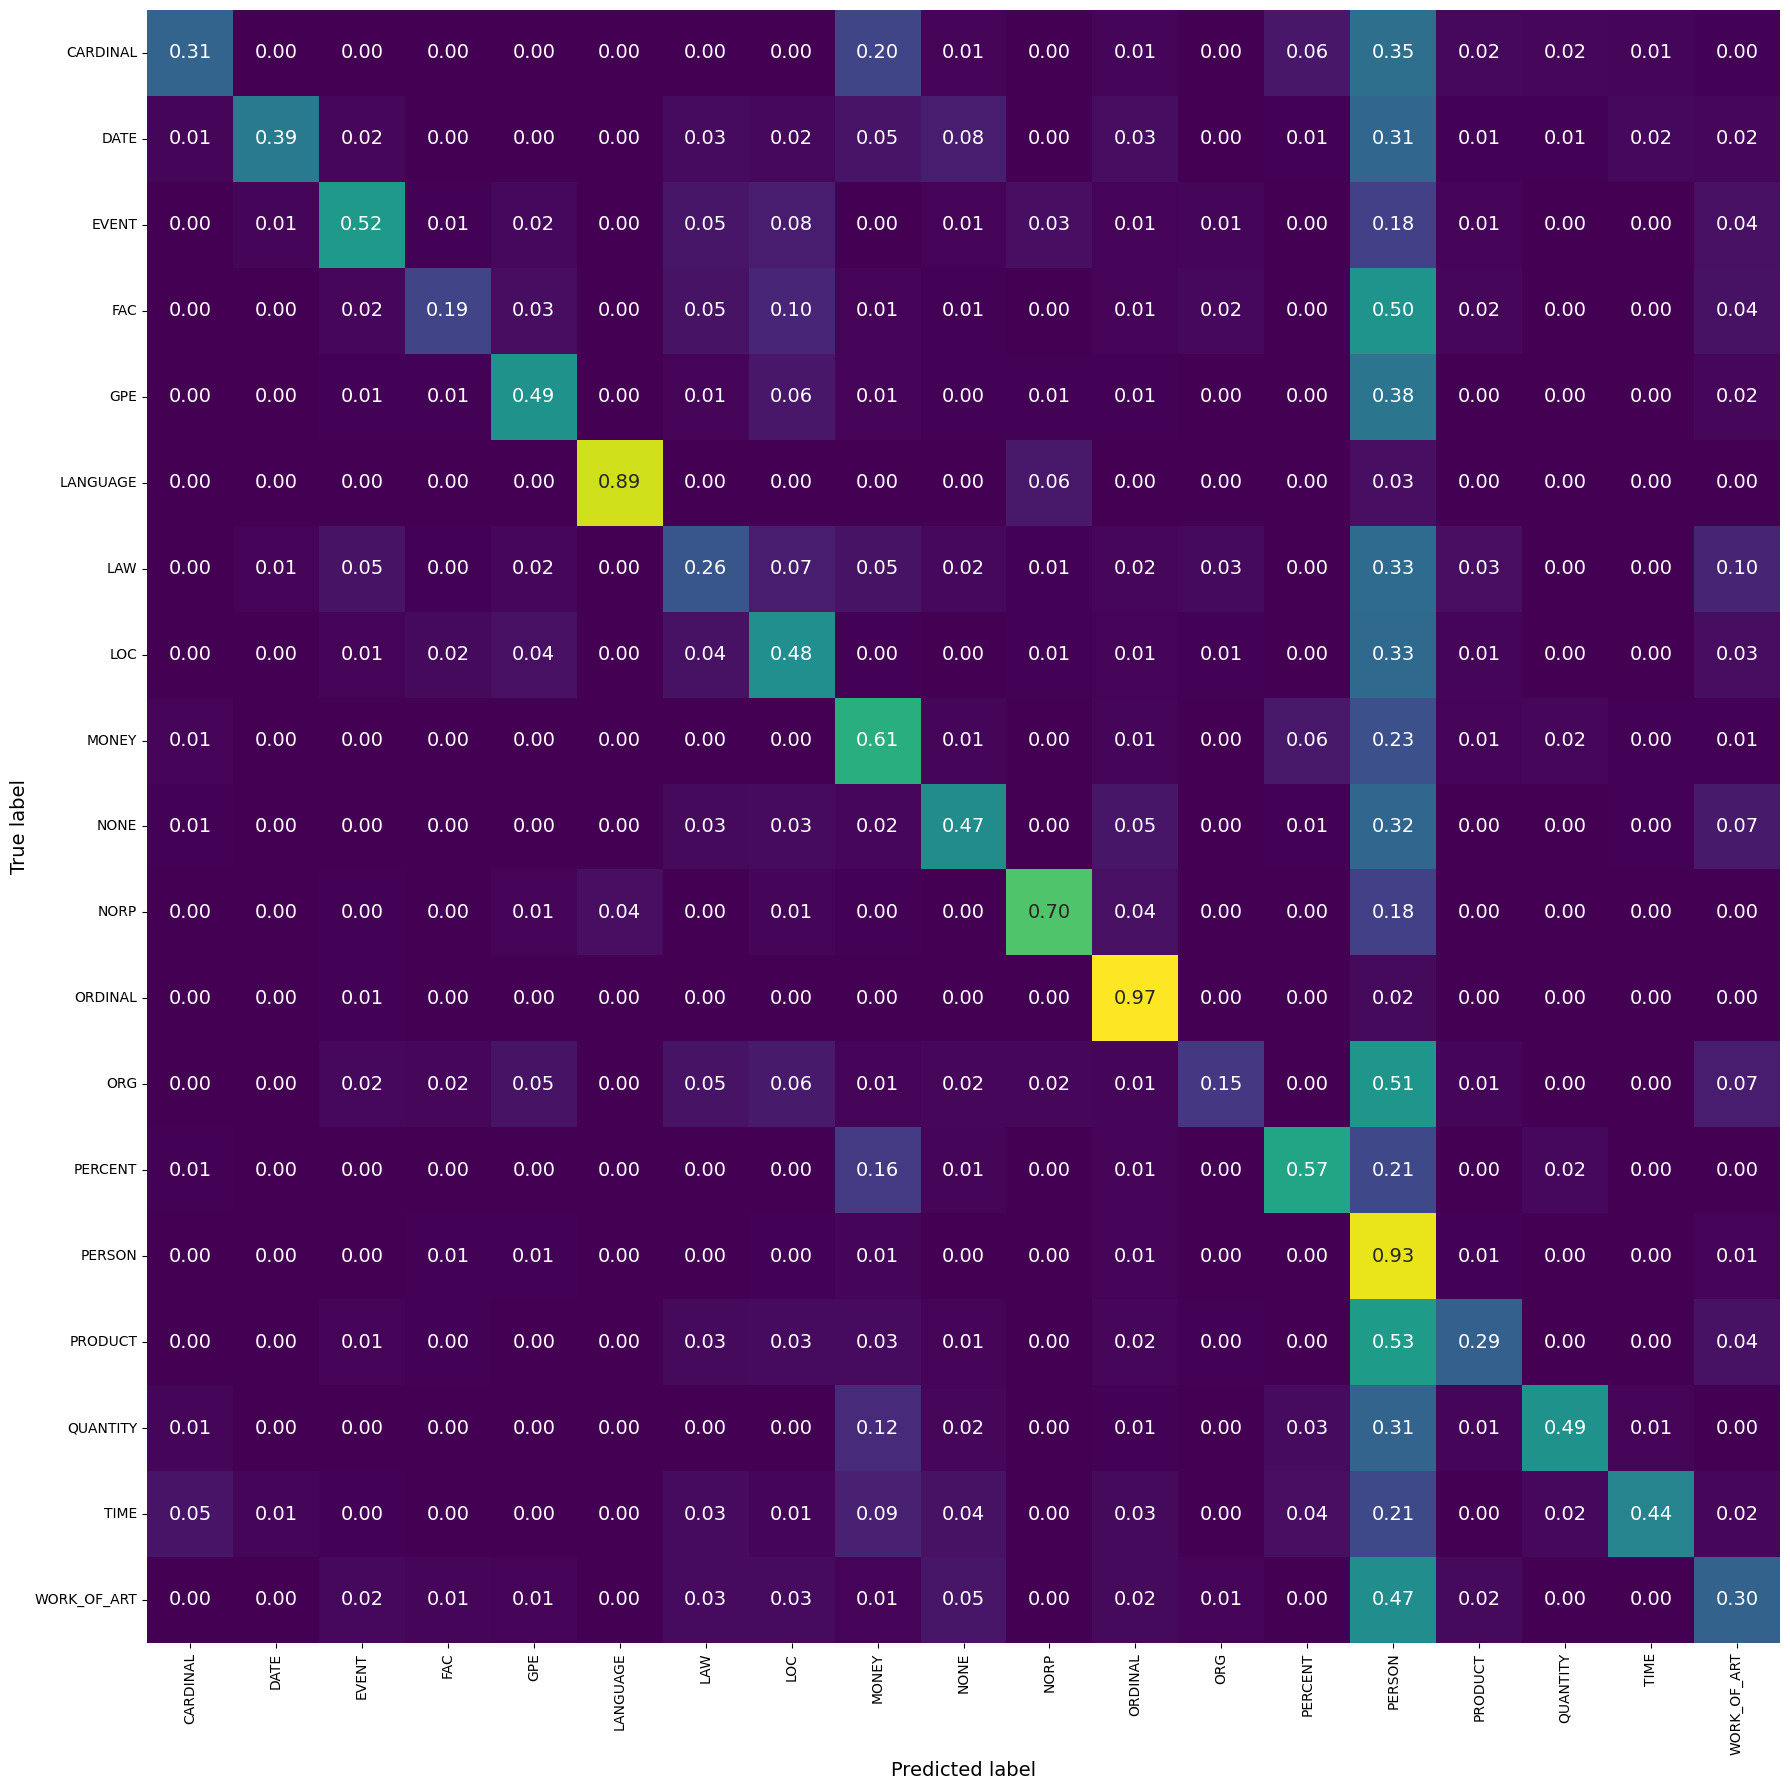

In [15]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [16]:
features = dict_vec.get_feature_names_out()
columns = encoder_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [17]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001407
EVENT          0.000703
FAC            0.000494
GPE            0.000419
WORK_OF_ART    0.000326
PERSON         0.000275
NONE           0.000058
LOC            0.000000
MONEY          0.000000
DATE           0.000000
NORP           0.000000
ORDINAL        0.000000
LAW            0.000000
PERCENT        0.000000
LANGUAGE       0.000000
PRODUCT        0.000000
QUANTITY       0.000000
TIME           0.000000
CARDINAL       0.000000
Name: token=EU, dtype: float64

In [18]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.226671
token=Arabic        0.053952
token=Hebrew        0.052232
token=Spanish       0.035967
token=Filipino      0.035480
token=French        0.033900
token=Latin         0.024227
token=Russian       0.015833
token=Chinese       0.015761
token=Mandarin      0.013290
token=German        0.012800
token=Portuguese    0.012505
token=Cantonese     0.011168
token=Japanese      0.009350
token=Polish        0.008945
Name: LANGUAGE, dtype: float64